# Attention Visualization

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoModel, AutoModelForQuestionAnswering, AutoTokenizer
from einops import rearrange, reduce, repeat
from transformers import BertPreTrainedModel, BertModel, RobertaModel
from torch.nn import Module, Linear, LayerNorm, CrossEntropyLoss

In [2]:
class DyReF(BertPreTrainedModel):

    def __init__(self, config, aggregation="mean", masking="full"):
        super().__init__(config)

        self.encoder_name = config.model_type
        if "roberta" in self.encoder_name:
            self.bert = RobertaModel(config)
        else:
            self.bert = BertModel(config)

        self.prefixes = nn.Parameter(data=torch.randn(2, config.hidden_size) * 0.02)

        self.aggregation = aggregation

        if self.aggregation == "weighted":
            self.att_ag = nn.Sequential(
                nn.Linear(config.hidden_size, 128),
                nn.LayerNorm(128),
                nn.ReLU(),
                nn.Linear(128, 1)
            )

        self.masking = masking

        self.init_weights()

    def mask_no_modify_input(self, new_att):
        new_att = new_att.unsqueeze(-2)
        size = new_att.size(-1)
        eye = torch.ones((size, size))

        # input cannot attend to queries
        eye[2:, :2] = 0

        # queries cannot attend to each other
        if self.masking == "independent":
            eye[0, 1] = 0
            eye[1, 0] = 0
        # start query cannot attend to end query
        elif self.masking == "causal":
            eye[0, 1] = 0
        elif self.masking == "bidirectionnal":
            eye = eye
        else:
            raise ValueError

        eye = eye.unsqueeze(0).to(new_att.device)

        return eye * new_att

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                start_positions=None, end_positions=None):

        B, L = input_ids.size()

        # word embedding
        w_embeddings = self.bert.embeddings.word_embeddings.forward(input_ids)

        # embedding with prefix
        queries = self.prefixes.unsqueeze(0).repeat(B, 1, 1)
        input_embeddings = torch.cat([queries, w_embeddings], dim=1)

        # compute contextual
        bert_out = self.bert(inputs_embeds=input_embeddings,
                           attention_mask=self.extends_attention_mask(attention_mask),
                           token_type_ids=self.extends_token_types(token_type_ids))

        all_hidden = torch.stack(bert_out[-2][1:]) # N, B, L, D
        
        attention = bert_out[-1]

        if self.aggregation == "mean":
            queries = all_hidden[:, :, :2, :].mean(0).transpose(0, 1)
        elif self.aggregation == "last":
            queries = all_hidden[-1, :, :2, :].transpose(0, 1)
        elif self.aggregation == "max":
            queries = all_hidden[:, :, :2, :].max(0).values.transpose(0, 1)
        elif self.aggregation == "weighted":
            queries = all_hidden[:, :, :2, :] # N, B, 2, D
            token_score = self.att_ag(queries) # N, B, 2, 1
            queries = (queries * token_score).sum(0).transpose(0, 1)

        # remove queries to get sequence representation
        x = bert_out[0][:, 2:, :]  # B, L, D

        # start/end logits
        start_logits, end_logits = torch.einsum('cbd,bld->cbl', queries, x)

        if attention_mask is not None:
            start_logits = start_logits + (1 - attention_mask) * -10000.0
            end_logits = end_logits + (1 - attention_mask) * -10000.0

        outputs = (start_logits, end_logits)

        if start_positions is not None and end_positions is not None:
            ignored_index = start_logits.size(1)
            start_positions.clamp_(0, ignored_index)
            end_positions.clamp_(0, ignored_index)

            loss_fct = CrossEntropyLoss(ignore_index=ignored_index)
            start_loss = loss_fct(start_logits, start_positions.long())
            end_loss = loss_fct(end_logits, end_positions.long())

            total_loss = (start_loss + end_loss) / 2
            outputs = (total_loss,) + outputs

        return outputs, attention

    def extends_attention_mask(self, attention_mask):

        if attention_mask is None:
            return attention_mask

        B, L = attention_mask.size()
        new_att = torch.zeros(B, L + 2).type_as(attention_mask)
        new_att[:, 2:] = attention_mask
        
        print(new_att)

        return new_att

    def extends_token_types(self, token_type_ids):

        if token_type_ids is None:
            return token_type_ids

        B, L = token_type_ids.size()
        new_tok = torch.zeros(B, L + 2).type_as(token_type_ids)
        new_tok[:, 2:] = token_type_ids

        return new_tok

In [3]:
# modify this
pretrained_dir = "/gpfswork/rech/ohy/upa43yu/DyREx/train_logs_old/spanbert_last_42/squad_full_spanbert_last"
model_path = "/gpfswork/rech/pds/upa43yu/models/spanbert-base-cased"

model = DyReF.from_pretrained(pretrained_dir,
                             output_attentions=True)

tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of the model checkpoint at /gpfswork/rech/ohy/upa43yu/DyREx/train_logs_old/spanbert_last_42/squad_full_spanbert_last were not used when initializing DyReF: ['out_q.2.weight', 'out_q.2.bias', 'out_q.0.weight', 'out_q.0.bias']
- This IS expected if you are initializing DyReF from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DyReF from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [5]:
def get_pen():   
    text = "[CLS] Where is the pen ? [SEP] There is a red book on the desk and a green pen on the chair [SEP]"

    tokens = tokenizer.tokenize(text)

    input_ids = tokenizer.encode(text="Where is the pen ?",
                                 text_pair="There is a red book on the desk and a green pen on the chair")

    t_input_ids = torch.LongTensor([input_ids])

    with torch.no_grad():
        out, att = model(t_input_ids)

    col = ["$q_s$", "$q_e$"] + tokens
    
    # max pooling of layers and heads
    im = torch.stack(att).max(0).values.squeeze().max(0).values.numpy()
    data = pd.DataFrame(im[:2, :], col[:2], col)
    return data

def get_book():   
    text = "[CLS] Where is the book ? [SEP] There is a red book on the desk and a green pen on the chair [SEP]"

    tokens = tokenizer.tokenize(text)

    input_ids = tokenizer.encode(text="Where is the book ?",
                                 text_pair="There is a red book on the desk and a green pen on the chair")

    t_input_ids = torch.LongTensor([input_ids])

    with torch.no_grad():
        out, att = model(t_input_ids)

    col = ["$q_s$", "$q_e$"] + tokens
    
    # max pooling of layers and heads
    im = torch.stack(att).max(0).values.squeeze().max(0).values.numpy()
    
    data = pd.DataFrame(im[:2, :], col[:2], col)
    
    return data

data_book = get_book()
data_pen = get_pen()

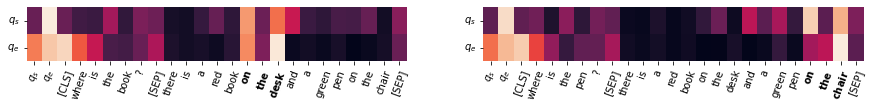

In [6]:
# format text for latex

# highlight span answer
new_c = list(data_pen.columns)
new_c[21:24] = [r"$\bf{on}$", r"$\bf{the}$", r"$\bf{chair}$"]
data_pen.columns = new_c
new_c = list(data_book.columns)
new_c[14:17] = [r"$\bf{on}$", r"$\bf{the}$", r"$\bf{desk}$"]
data_book.columns = new_c

data = [data_book, data_pen]

fig, axn = plt.subplots(1, 2)
fig.set_figheight(1)
fig.set_figwidth(15)

for i, ax in enumerate(axn.flat):
    chart = sns.heatmap(data[i], ax=ax, cbar=False)
    
    chart.set_xticklabels(chart.get_xticklabels(), rotation=70)
    chart.set_yticklabels(chart.get_yticklabels(), rotation=0)
    
plt.savefig('visualization.pdf', transparent=True, format="pdf", bbox_inches = 'tight', dpi=500)